In [509]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import h5py
from PIL import Image

from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
#from sklearn.linear_model import LogisticRegression #<--this was a poor classifier compared to the decision tree.
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

sns.set()
%matplotlib inline

In [416]:
def identify_mismatches(x,y,y_pred,cats):
    mismatch_list = []
    for idx,prd in enumerate(y_pred):
        if y_pred[idx] != y[idx]:
            mismatch_list.append([idx,1 if [y[idx],y_pred[idx]] == [1,0] else 0])
    print('Total misclassified images: {:.6}%'.format(len(mismatch_list) / len(x) * 100))
    print('Percentage of cat images not classified as cats: {:.6}%'.format(sum(map(lambda x: x[1],mismatch_list)) / cats[1][1] * 100))
    print('Percentage of other images classified as cats: {:.6}%'.format(sum(map(lambda x: 1 if x[1] == 0 else 0,mismatch_list)) / cats[1][0] * 100))    

# I love cats. I love every kind of cat.
## So, let's build a model to identify pictures of cats!

I downloaded the datasets I'm using for this challenge from [this Kaggle page](https://www.kaggle.com/mriganksingh/cat-images-dataset).

The uploader of the dataset included kernels as well--I largely avoided looking at them, except for a quick glance to understand how to look at images, to make sure I loaded the dataset correctly. (The answer is simply plt.imshow().)
* I learned how to open HDF5 files [here](http://docs.h5py.org/en/stable/index.html).
* I took a stab at trying to read the data directly from the .zip file, using [this reference](https://docs.python.org/3/library/zipfile.html) as a guide, but didn't want to burn too much time on it right now.

The .zip file contains  a training set and a test set--the training set has 209 images, with an accompanying indicator classifying the image as cat or non-cat. The test set is 50 images.

Identifying cats is not super useful, but in general, image recognition has all kinds of applications, including health care (recognizing abnormalities in X-rays and CT scans for instance), law enforcement, and social media, to name three off the top of my head.

In [417]:
f = h5py.File('cat-images-dataset/train_catvnoncat.h5','r')

## Exploring the data

Peek at what's available in the file we read:

In [418]:
list(f.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [419]:
train_set_x = np.array(f['train_set_x'])
train_set_y = np.array(f['train_set_y'])

In [420]:
for cl in f['list_classes']:
    print(cl)

b'non-cat'
b'cat'


Here's a pair of sample images from the training dataset--one is a cat, and one is not:

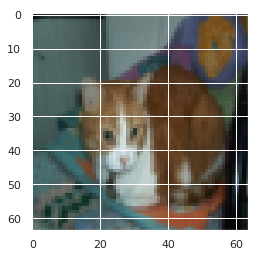

In [421]:
ax = plt.imshow(train_set_x[134])

Kitty. 😻

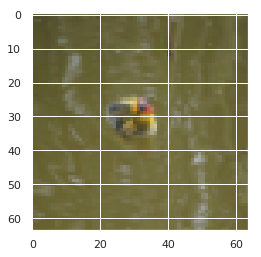

In [422]:
ax2 = plt.imshow(train_set_x[130])

Here's the training set's dependent variable:

In [423]:
train_set_y

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

Here are the counts of non-cat and cat images, respectively:

In [424]:
training_cats = np.unique(train_set_y,return_counts=True)
training_cats

(array([0, 1]), array([137,  72]))

## Prepping the data

I wasn't able to feed the training set to this model as-is--the model requires input of 2 or fewer dimensions.

I've returned to this point a few times, each time trying to do things to simplify the input data, and reshape it so the model will accept it.

My first approach was to try flatten the array.

Next up: before flattening, I convert the images to grayscale, so the model will not have to care about color. I first accomplished this using code I cribbed from [a different discussion](https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python)--then I discovered Pillow, and liked the simplicity, so I ran with it.

Creating an image object and converting it to grayscale became a one-line comprehension:

In [425]:
greycats = [Image.fromarray(x).convert('L') for x in f['train_set_x']]

Displaying an image is as simple as this--no call to another function needed:

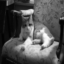

In [426]:
#plt.imshow(greycats[7])   #<--nope!
greycats[7]                #<--much simpler!

And flattening the image so it can be fed to the model is still this easy:

In [427]:
d2_train_set_x = np.array([np.array(x).flatten() for x in greycats])

In [428]:
d2_train_set_x.shape

(209, 4096)

In [429]:
d2_train_set_x

array([[ 29,  32,  35, ...,   0,   0,   0],
       [192, 187, 181, ...,  82,  82,  80],
       [ 73,  84,  99, ..., 155, 147, 140],
       ...,
       [152, 189, 147, ..., 103, 106, 105],
       [ 23,  24,  25, ...,   4,   4,   4],
       [ 24,  30,  33, ...,   0,   0,   0]], dtype=uint8)

## The model

We were asked to use a Restricted Boltzmann Machine for this challenge.

I read up--to get this to work, the output of the RBM needs to be fed to some kind of classifier model for the final classification. Every example I saw accomplished that via a Pipeline. Most examples used a logistic regression model, so I will start with that as well.

In [510]:
# Thanks to Tiago for coaching me through setting the parameters for the RBM model
rbm = BernoulliRBM(learning_rate=10**-8, n_iter=150, n_components=200,verbose=True)

#logistic = LogisticRegression(solver='lbfgs', 
#                 max_iter=10000,C=6000, multi_class='multinomial')

tree = RandomForestClassifier(n_estimators=150)

#Combine the two into a Pipeline
#rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

#Combine the two into a Pipeline
rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('tree', tree)])

In [511]:
rbm_features_classifier.fit(d2_train_set_x,train_set_y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -29771.96, time = 0.46s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -33850.97, time = 0.58s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -26059.95, time = 0.53s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -26994.54, time = 0.53s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -29920.62, time = 0.51s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -30716.92, time = 0.49s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -36271.08, time = 0.52s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -26784.60, time = 0.51s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -26959.36, time = 0.54s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -23971.88, time = 0.49s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -27045.01, time = 0.43s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -27480.88, time = 0.48s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -19640.43, time = 0.52s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -24610.48, 

[BernoulliRBM] Iteration 116, pseudo-likelihood = -74.77, time = 0.54s
[BernoulliRBM] Iteration 117, pseudo-likelihood = -68.13, time = 0.52s
[BernoulliRBM] Iteration 118, pseudo-likelihood = -56.25, time = 0.54s
[BernoulliRBM] Iteration 119, pseudo-likelihood = -64.46, time = 0.66s
[BernoulliRBM] Iteration 120, pseudo-likelihood = -64.60, time = 0.51s
[BernoulliRBM] Iteration 121, pseudo-likelihood = -37.81, time = 0.50s
[BernoulliRBM] Iteration 122, pseudo-likelihood = -45.79, time = 0.47s
[BernoulliRBM] Iteration 123, pseudo-likelihood = -44.10, time = 0.51s
[BernoulliRBM] Iteration 124, pseudo-likelihood = -1364.33, time = 0.50s
[BernoulliRBM] Iteration 125, pseudo-likelihood = -105.32, time = 0.48s
[BernoulliRBM] Iteration 126, pseudo-likelihood = -45.11, time = 0.49s
[BernoulliRBM] Iteration 127, pseudo-likelihood = -61.09, time = 0.51s
[BernoulliRBM] Iteration 128, pseudo-likelihood = -54.50, time = 0.46s
[BernoulliRBM] Iteration 129, pseudo-likelihood = -597.30, time = 0.50s
[B

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=1e-08,
                              n_components=200, n_iter=150, random_state=None,
                              verbose=True)),
                ('tree',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=None,
                                     

In [512]:
Y_pred = rbm_features_classifier.predict(d2_train_set_x)

metrics.classification_report(train_set_y, Y_pred)

'              precision    recall  f1-score   support\n\n           0       0.91      1.00      0.95       137\n           1       1.00      0.82      0.90        72\n\n    accuracy                           0.94       209\n   macro avg       0.96      0.91      0.93       209\nweighted avg       0.94      0.94      0.94       209\n'

In [513]:
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

1. Using the logistic regression model as the classifier, other settings as follows:

```
rbm = BernoulliRBM(learning_rate=10**-8, n_iter=300, n_components=150,verbose=True)

logistic = LogisticRegression(solver='lbfgs', 
                 max_iter=10000,C=6000, multi_class='multinomial')
```               
Results:
```
'              precision    recall  f1-score   support\n\n           0       0.66      0.99      0.80       137\n           1       0.75      0.04      0.08        72\n\n    accuracy                           0.67       209\n   macro avg       0.71      0.52      0.44       209\nweighted avg       0.69      0.67      0.55       209\n'
```
Y_pred:
```
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
```

2. Using the decision tree model as the classifier, other settings as follows:

```
rbm = BernoulliRBM(learning_rate=10**-8, n_iter=300, n_components=150,verbose=True)

logistic = LogisticRegression(solver='lbfgs', 
                 max_iter=10000,C=6000, multi_class='multinomial')

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
```

Results:
```
'              precision    recall  f1-score   support\n\n           0       0.74      1.00      0.85       137\n           1       1.00      0.33      0.50        72\n\n    accuracy                           0.77       209\n   macro avg       0.87      0.67      0.68       209\nweighted avg       0.83      0.77      0.73       209\n'
```

Y_pred:
```
array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
```

This is a drastic improvement over the logistic regression model. We'll stick with a decision tree from here out.

3. Using the decision tree model as the classifier, other settings as follows:

```
rbm = BernoulliRBM(learning_rate=10**-8, n_iter=300, n_components=150,verbose=True)

logistic = LogisticRegression(solver='lbfgs', 
                 max_iter=10000,C=6000, multi_class='multinomial')

tree = DecisionTreeClassifier(criterion='entropy')
```
Results:
```
'              precision    recall  f1-score   support\n\n           0       0.69      1.00      0.82       137\n           1       1.00      0.15      0.27        72\n\n    accuracy                           0.71       209\n   macro avg       0.85      0.58      0.54       209\nweighted avg       0.80      0.71      0.63       209\n'
```

Y_pred:
```
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
```

This is worse than using 'gini' as the criterion. I'm going to stick with the second run.

### When the model went wrong, how did it go wrong?

I ran and reran the model, tweaking parameters. I saw the most drastic improvement when I began reducing the number of iterations for the RBM--it was as high as 300 iterations, but with each reduction (200,175,150) I saw better results. At 125, the outcome looked worse again, so I think 150 iterations might be the sweet spot between the model not learning enough, and overfitting to the training data.

In [514]:
identify_mismatches(train_set_x,train_set_y,Y_pred,training_cats)

Total misclassified images: 6.2201%
Percentage of cat images not classified as cats: 18.0556%
Percentage of other images classified as cats: 0.0%


## Feed the test set of images to the model. How well does it perform?

In [438]:
f = h5py.File('cat-images-dataset/test_catvnoncat.h5','r')

In [439]:
f.keys()

<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

In [440]:
test_set_x = np.array(f['test_set_x'])
test_set_y = np.array(f['test_set_y'])

In [441]:
test_cats = np.unique(test_set_y,return_counts=True)
test_cats

(array([0, 1]), array([17, 33]))

In [442]:
greycats_test = [Image.fromarray(x).convert('L') for x in f['test_set_x']]

In [443]:
d2_test_set_x = np.array([np.array(x).flatten() for x in greycats_test])

In [515]:
Y_pred_test = rbm_features_classifier.predict(d2_test_set_x)

metrics.classification_report(test_set_y, Y_pred_test)

'              precision    recall  f1-score   support\n\n           0       0.36      0.88      0.51        17\n           1       0.75      0.18      0.29        33\n\n    accuracy                           0.42        50\n   macro avg       0.55      0.53      0.40        50\nweighted avg       0.62      0.42      0.37        50\n'

In [516]:
Y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0])

In [523]:
test_set_y

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 0])

In [517]:
identify_mismatches(test_set_x,test_set_y,Y_pred_test,test_cats)

Total misclassified images: 58.0%
Percentage of cat images not classified as cats: 81.8182%
Percentage of other images classified as cats: 11.7647%


I have not seen the same improvement in the test set as I did in the training set. This makes me believe that the model is perhaps overfitting, or the test set of images is too different from the training set.

Honestly this is kind of a tough dataset to fit, given the variety in the cat images. Given the simplicity of the MNIST set, for example, this was probably not the best starting point for a new learner.

Some examples of images from the test set:

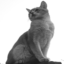

In [518]:
greycats_test[6] # Correctly identified as a cat

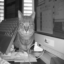

In [520]:
greycats_test[7] # Incorrectly identified as non-cat. It has a noisy background.

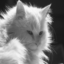

In [521]:
greycats_test[8] # Correctly identified as a cat 

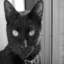

In [522]:
greycats_test[9] # Also incorrectly identified as non-cat.

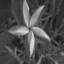

In [525]:
greycats_test[16] # Incorrectly identified as a cat!

I'm just learning about image recognition, but maybe further reducing the input to edges before feeding it to the model would help? 